スパースモデリング第10章
==
# 画像のボケ除去：実践例


In [ ]:
from matplotlib.font_manager import FontProperties

font_path = u'/Library/Fonts/ヒラギノ角ゴ Pro W3.otf'
font_prop = FontProperties(fname=font_path)
plt.rc('font',family=font_prop.get_name())

原画像
--

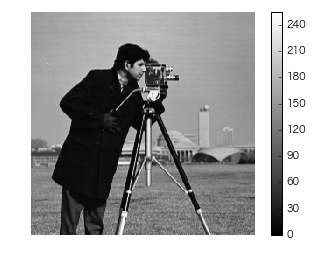

In [81]:
from skimage.data import camera

im = camera().astype(np.float)[::2, ::2]
plt.imshow(im, cmap='gray', interpolation='Nearest')
plt.axis('off')
plt.colorbar()

（非縮小）ウェーブレット変換
--

(0.0, 1.0, 0.0, 1.0)

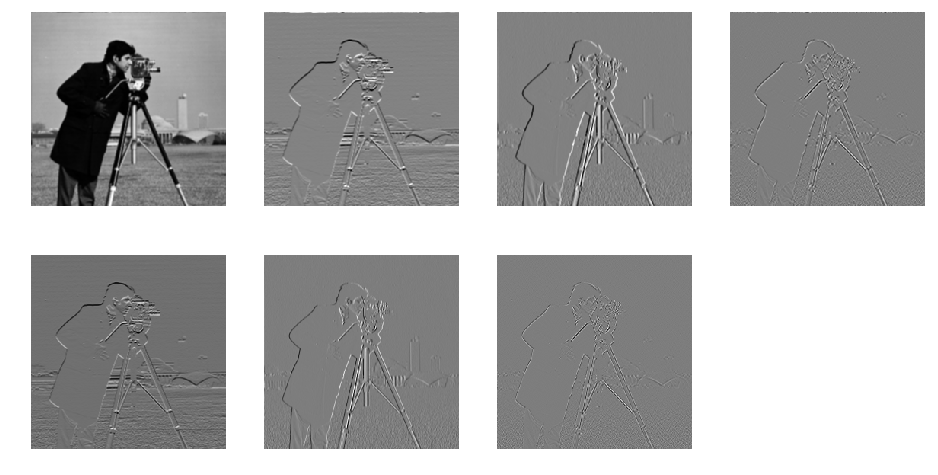

In [2]:
def horizontal(im):
    im2 = np.roll(im, 1, axis=1)
    return (im + im2) / 2., (im - im2) / 2.

def vertical(im):
    im2 = np.roll(im, 1, axis=0)
    return (im + im2) / 2., (im - im2) / 2.

def wavelet(im):
    l, h = horizontal(im)
    hl, hh = vertical(h)
    ll, lh = vertical(l)
    return ll, lh, hl, hh

def wavelet2(im):
    ll, lh, hl, hh = wavelet(im)
    ll2, lh2, hl2, hh2 = wavelet(ll)
    return np.array([ll2, lh2, hl2, hh2, lh, hl, hh])
    
coeffs = wavelet2(im)

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax = ax.flatten()
for i, coef in enumerate(coeffs):
    ax[i].imshow(coef, cmap='gray', interpolation='Nearest')
    ax[i].axis('off')
ax[-1].axis('off')

ボケカーネルを得る
--

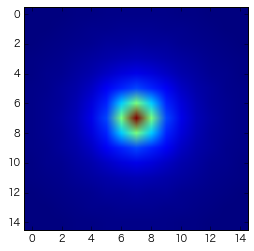

In [3]:
def get_blur_kernel():
    """ ボケカーネルを得る """
    x = np.arange(-7, 8)
    y = np.arange(-7, 8)
    xx, yy = np.meshgrid(x, y)
    return 1. / (xx ** 2 + yy ** 2 + 1)
 
h = get_blur_kernel()
h /= h.sum()
plt.imshow(h)

ノイズありボケ画像を得る
--
* $\sigma^{2} = 2$

(-0.5, 255.5, 255.5, -0.5)

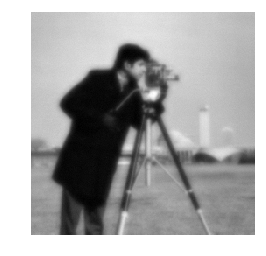

In [4]:
from scipy.signal import convolve2d

y_bar = convolve2d(im, h, mode='same', boundary='symm') + np.random.randn(256, 256) * np.sqrt(2.)

plt.imshow(y_bar, cmap='gray', interpolation='Nearest')
plt.axis('off')

反復縮小アルゴリズム
--

In [63]:
from scipy.optimize import minimize_scalar, minimize

class IterativeShrinkage(object):
    """ 反復縮小アルゴリズム """
    def __init__(self, b, s, lam):
        self.b = b
        self.eps = 0
        self.s = s
        self.lam = lam
        self.c = 1.
       
    def horizontal(self, im):
        """ 水平方向にフィルタリング """
        im2 = np.roll(im, 1, axis=1)
        return (im + im2) / 2., (im - im2) / 2.

    def vertical(self, im):
        """ 垂直方向にフィルタリング """
        im2 = np.roll(im, 1, axis=0)
        return (im + im2) / 2., (im - im2) / 2.

    def wavelet(self, im):
        """ レベル1（非縮小）ウェーブレット変換 """
        l, h = self.horizontal(im)
        hl, hh = self.vertical(h)
        ll, lh = self.vertical(l)
        return ll, lh, hl, hh

    def wavelet2(self, im):
        """ レベル2（非縮小）ウェーブレット変換 """
        ll, lh, hl, hh = self.wavelet(im)
        ll2, lh2, hl2, hh2 = self.wavelet(ll)
        return np.array([ll2, lh2, hl2, hh2, lh, hl, hh])

    def forward(self, x):
        """ 順投影 """
        return convolve2d(np.sum(x, axis=0), h, mode='same', boundary='symm')  

    def backward(self, y):
        """ 逆投影 """
        return wavelet2(convolve2d(y, h, mode='same', boundary='symm'))

    def shrink(self, x):
        """ 縮小 """
        s, lam = self.s, self.lam
        ndx = x < 0
        x[ndx] *= -1
        x = (x - s - lam + np.sqrt((s + lam - x) ** 2 + 4. * s * x)) / 2.
        x[ndx] *= -1
        return x

    def rho(self, x):
        """ 関数ρ(x) """
        return np.abs(x) + self.s * np.log(1. + np.abs(x) / self.s)
    
    def f(self, x, y):
        """ 目標関数 """
        return self.lam * np.sum(self.rho(x)) + 0.5 * np.sum((self.b - y) ** 2)

    def line(self, x, gx, y, gy):
        """ 直線探索 """
        
        def f_ls(mu, *args):
            """ 目標関数 """
            x, gx, y, gy = args
            x_new = x + mu * gx
            e = self.b - (y + mu * gy)
            return self.lam * np.sum(self.rho(x_new)) + 0.5 * np.sum(e ** 2)

        res = minimize_scalar(f_ls, args=(x, gx, y, gy))
        return res.x                  
    
    def sesop(self, x, ses_gx, y, ses_gy, q):
        """ 逐次的部分空間最適化 """
    
        def f_sesop(mu, *args):
            """ 目標関数 """
            x, ses_gx, y, ses_gy, q = args
            gx = ses_gx[0] * mu[0]
            gy = ses_gy[0] * mu[0]
            for i in range(1, q + 1):
                gx += ses_gx[i] * mu[i]
                gy += ses_gy[i] * mu[i]
            x_new = x + gx
            e = self.b - (y + gy)
            return self.lam * np.sum(self.rho(x_new)) + 0.5 * np.sum(e ** 2)

        res = minimize(f_sesop, np.ones(q + 1), args=(x, ses_gx, y, ses_gy, q))
        return res.x
    
    def SSF(self, niter=50, ls=False, sesop=False, q=5, x0=None):
        """ 分割可能代理汎関数（separable surrogate functional; SSF） """
        y = np.zeros_like(self.b)
        x = self.backward(y)
        r = self.b.copy()      
        ses_gx = np.zeros((q + 1, x.shape[0], x.shape[1], x.shape[2]))
        ses_gy = np.zeros((q + 1, y.shape[0], y.shape[1]))
            
        fs = []
        errs = []
        for k in range(niter):
            fs.append(self.f(x, y))
            if x0 is not None:
                x_hat = np.sum(x, axis=0)
                errs.append(np.sum((x_hat - x0) ** 2) / np.sum(x0 ** 2))
                print(k, errs[-1])
            e = self.backward(r)
            e_s = self.shrink(x + e / self.c)
            gx = e_s - x
            if sesop:
                ses_gx[k % (q + 1)] = gx
                ses_gy[k % (q + 1)] = self.forward(gx)
                q2 = min(q, k)
                res = self.sesop(x, ses_gx, y, ses_gy, q2)
                u = ses_gx[0] * res[0]
                for i in range(1, q2 + 1):
                    u += ses_gx[i] * res[i]
            elif ls:
                u = self.line(x, gx, y, self.forward(gx)) * gx
            else:
                u = gx
            x += u
            y = self.forward(x)
            r = self.b - y
            if np.sum(u ** 2) < self.eps:
                return x, fs, errs
        return x, fs, errs

分割可能代理汎関数（separable surrogate functional; SSF）
--

In [59]:
iterative_shrinkage = IterativeShrinkage(y_bar, 0.01, 0.075)
x, fs, errs = iterative_shrinkage.SSF(niter=100, x0=im)

0 1.0
1 0.03052665342
2 0.023415301634
3 0.0201904735695
4 0.0181432484526
5 0.0166531406191
6 0.0154900103214
7 0.0145437890763
8 0.0137528977518
9 0.0130790708066
10 0.0124968059573
11 0.0119874524338
12 0.0115378801427
13 0.0111381428212
14 0.0107802829741
15 0.0104580956087
16 0.0101665715344
17 0.00990159345166
18 0.00965982967208
19 0.00943841952031
20 0.00923499411808
21 0.0090474575346
22 0.00887398422633
23 0.00871318032178
24 0.00856374910768
25 0.00842433455151
26 0.00829403789482
27 0.00817207357682
28 0.0080577515023
29 0.00795035202637
30 0.0078492524823
31 0.00775396692634
32 0.00766392997619
33 0.00757864843232
34 0.00749777518431
35 0.00742100964958
36 0.00734807675598
37 0.00727871742579
38 0.00721269726538
39 0.00714984260711
40 0.00708989403067
41 0.00703268331789
42 0.00697799244682
43 0.00692573470578
44 0.00687573094602
45 0.00682783496501
46 0.00678189553941
47 0.00673782344356
48 0.00669551583141
49 0.00665491142654
50 0.00661594636492
51 0.0065784917484
52 0.0

直線探索付きSSF（SSF-LS）
--

In [79]:
iterative_shrinkage = IterativeShrinkage(y_bar, 0.01, 0.075)
x2, fs2, errs2 = iterative_shrinkage.SSF(niter=60, ls=True, x0=im)

0 1.0
1 0.0304124193584
2 0.0203672463498
3 0.0167524799043
4 0.014739616276
5 0.0132366518593
6 0.0121833546699
7 0.011304486634
8 0.0106381467181
9 0.010059270234
10 0.00959794472959
11 0.00919034968363
12 0.00885376708837
13 0.00855209310329
14 0.0082964289149
15 0.00806374205568
16 0.00786390630194
17 0.00767936227802
18 0.00751893406901
19 0.00736806392344
20 0.00723713108239
21 0.00711160221401
22 0.00700335798786
23 0.00689749273179
24 0.00680705190477
25 0.00671648076008
26 0.00664001219087
27 0.00656196015788
28 0.00649707321368
29 0.00642930082045
30 0.00637395935301
31 0.00631441649411
32 0.00626669942544
33 0.00621422067722
34 0.00617285885221
35 0.0061265993059
36 0.00609085514051
37 0.00605028607868
38 0.00601923543432
39 0.0059833043799
40 0.00595652914155
41 0.00592507371008
42 0.0059019790706
43 0.00587439486
44 0.0058544581821
45 0.0058306271698
46 0.00581362609278
47 0.00579324838685
48 0.0057788501105
49 0.00576136009758
50 0.00574929598966
51 0.00573470409771
52 0.

逐次部分空間最適化（SESOP; sequential subspace optimization）付きSSF（SSF-SESOP-5）
--

In [66]:
iterative_shrinkage = IterativeShrinkage(y_bar, 0.01, 0.075)
x3, fs3, errs3 = iterative_shrinkage.SSF(niter=25, sesop=True, x0=im)

0 1.0
1 0.0304124194475
2 0.0203323968156
3 0.0155366823691
4 0.0124227380764
5 0.0102666086261
6 0.0090706456641
7 0.0090780437937
8 0.00846608155124
9 0.00786062698505
10 0.00730046115952
11 0.00705582754736
12 0.00675759851493
13 0.00645338619013
14 0.00623670895511
15 0.00607517528614
16 0.00591105995344
17 0.00587279847561
18 0.00580923497096
19 0.00573421146477
20 0.00569059543793
21 0.00565538581567
22 0.0056312384471
23 0.00562017054035
24 0.00561210274601


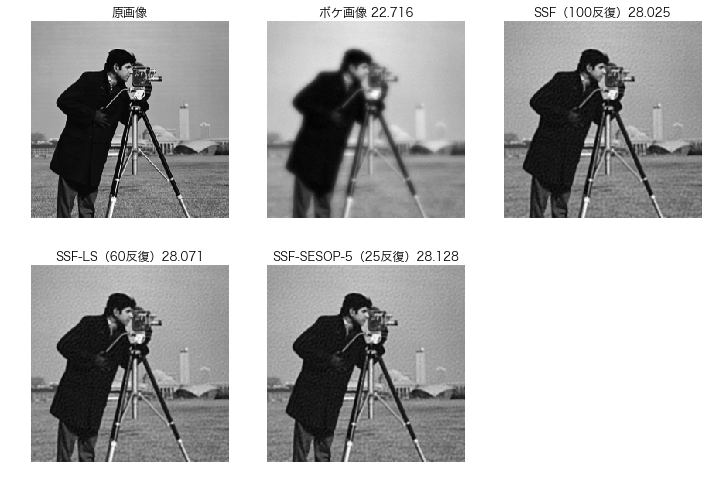

In [80]:
from skimage.measure import compare_psnr

y_hat = np.sum(x, axis=0)
y_hat2 = np.sum(x2, axis=0)
y_hat3 = np.sum(x3, axis=0)

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.flatten()
ax[0].imshow(im, cmap='gray', interpolation='Nearest')
ax[1].imshow(y_bar, cmap='gray', interpolation='Nearest')
ax[2].imshow(y_hat, cmap='gray', interpolation='Nearest')
ax[3].imshow(y_hat2, cmap='gray', interpolation='Nearest')
ax[4].imshow(y_hat3, cmap='gray', interpolation='Nearest')
ax[5].axis('off')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
ax[4].axis('off')
ax[0].set_title('原画像')
ax[1].set_title('ボケ画像 {:.3f}'.format(compare_psnr(im / 255, y_bar / 255)))
ax[2].set_title('SSF（100反復）{:.3f}'.format(compare_psnr(im / 255, y_hat / 255)))
ax[3].set_title('SSF-LS（60反復）{:.3f}'.format(compare_psnr(im / 255, y_hat2 / 255)))
ax[4].set_title('SSF-SESOP-5（25反復）{:.3f}'.format(compare_psnr(im / 255, y_hat3 / 255)))

plt.savefig('deblurring.png', dpi=220)